In [154]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pmdarima in c:\users\asus\appdata\local\programs\python\python311\lib\site-packages (2.0.4)




[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [156]:
historical_weather = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\historical_weather.csv")
test_data = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\submission_key.csv")

In [157]:
historical_weather.drop(columns=['snow_depth_mm'], inplace=True)

In [158]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [159]:
historical_weather['city_id'] = historical_weather['city_id'].str.extract('(\d+)').astype(int)
test_data['city_id'] = test_data['city_id'].str.extract('(\d+)').astype(int)

In [160]:
imputer = SimpleImputer(strategy='mean')

In [161]:
historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']] = imputer.fit_transform(historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])

In [162]:
historical_weather['temp_range'] = historical_weather['max_temp_c'] - historical_weather['min_temp_c']
historical_weather['cum_precip'] = historical_weather['precipitation_mm'].cumsum()
historical_weather['temp_precip_interaction'] = historical_weather['avg_temp_c'] * historical_weather['precipitation_mm']

# Temperature anomalies
historical_weather['temp_anomaly'] = historical_weather['avg_temp_c'] - historical_weather['avg_temp_c'].mean()

# Precipitation anomalies
historical_weather['precip_anomaly'] = historical_weather['precipitation_mm'] - historical_weather['precipitation_mm'].mean()

# Complex interactions
historical_weather['temp_precip_wind_interaction'] = historical_weather['avg_temp_c'] * historical_weather['precipitation_mm'] * historical_weather['avg_wind_speed_kmh']


In [163]:
historical_weather['rolling_mean_temp'] = historical_weather['avg_temp_c'].rolling(window=7).mean()
historical_weather['rolling_std_temp'] = historical_weather['avg_temp_c'].rolling(window=7).std()
historical_weather['rolling_sum_precip'] = historical_weather['precipitation_mm'].rolling(window=7).sum()

In [164]:
historical_weather['temp_deviation'] = historical_weather['avg_temp_c'] - historical_weather['avg_temp_c'].rolling(window=30).mean()
# Day-to-day temperature change
historical_weather['temp_day_change'] = historical_weather['avg_temp_c'] - historical_weather['avg_temp_c'].shift(1)
    
# Heavy precipitation indicator
historical_weather['heavy_precip'] = (historical_weather['precipitation_mm'] > 10).astype(int)
    
# Wind speed categories (example bins: calm, breeze, gale)
bins = [0, 5, 15, 30, np.inf]
labels = ['Calm', 'Breeze', 'Gale', 'Storm']
historical_weather['wind_speed_category'] = pd.cut(historical_weather['avg_wind_speed_kmh'], bins=bins, labels=labels)

# Wind direction sine and cosine components
historical_weather['wind_dir_sin'] = np.sin(np.radians(historical_weather['avg_wind_dir_deg']))
historical_weather['wind_dir_cos'] = np.cos(np.radians(historical_weather['avg_wind_dir_deg']))

# Temperature percentile rank
historical_weather['temp_percentile'] = historical_weather['avg_temp_c'].rank(pct=True)

# Cumulative moving average
historical_weather['cum_avg_temp'] = historical_weather['avg_temp_c'].expanding().mean()

In [165]:
day_of_year = historical_weather['date'].dt.dayofyear
historical_weather['fourier_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
historical_weather['fourier_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

In [166]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    df['season'] = df['season'].cat.codes
    return df

historical_weather = create_features(historical_weather)

In [167]:
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('city_id')[col].shift(lag)
    return df

In [168]:
lag_features = ['avg_temp_c']
lags = [1, 2, 3, 4, 5, 6, 7]  # 1-day, 2-day, 3-day, 7-day, 14-day, and 30-day lags
historical_weather = create_lag_features(historical_weather, lags, lag_features)

In [169]:
historical_weather

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,temp_range,cum_precip,...,weekofyear,date_offset,season,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,-1.4,11.6,3.679964,168.000000,6.2,13.0,3.679964,...,1,1081,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,6.3,13.3,3.679964,155.000000,10.0,7.0,7.359929,...,1,1082,3,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,1.9,14.0,3.679964,175.650289,5.8,12.1,11.039893,...,1,1083,3,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,3.9,13.3,3.679964,291.000000,11.3,9.4,14.719857,...,1,1084,3,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,0.5,16.9,3.679964,175.650289,5.0,16.4,18.399821,...,1,1085,3,7.6,7.6,9.3,6.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,15.9,27.9,0.000000,100.000000,13.2,12.0,670978.229896,...,52,907,3,22.3,21.9,20.6,19.3,18.5,19.2,21.0
182334,112,2018-12-28,21.9,14.9,28.2,0.000000,91.000000,12.6,13.3,670978.229896,...,52,908,3,22.0,22.3,21.9,20.6,19.3,18.5,19.2
182335,112,2018-12-29,22.4,16.3,28.2,0.000000,61.000000,14.2,11.9,670978.229896,...,52,909,3,21.9,22.0,22.3,21.9,20.6,19.3,18.5
182336,112,2018-12-30,21.6,18.5,26.6,1.600000,70.000000,17.0,8.1,670979.829896,...,52,910,3,22.4,21.9,22.0,22.3,21.9,20.6,19.3


In [170]:
historical_weather.columns

Index(['city_id', 'date', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh',
       'temp_range', 'cum_precip', 'temp_precip_interaction', 'temp_anomaly',
       'precip_anomaly', 'temp_precip_wind_interaction', 'rolling_mean_temp',
       'rolling_std_temp', 'rolling_sum_precip', 'temp_deviation',
       'temp_day_change', 'heavy_precip', 'wind_speed_category',
       'wind_dir_sin', 'wind_dir_cos', 'temp_percentile', 'cum_avg_temp',
       'fourier_sin', 'fourier_cos', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'date_offset', 'season',
       'avg_temp_c_lag_1', 'avg_temp_c_lag_2', 'avg_temp_c_lag_3',
       'avg_temp_c_lag_4', 'avg_temp_c_lag_5', 'avg_temp_c_lag_6',
       'avg_temp_c_lag_7'],
      dtype='object')

In [171]:
historical_weather = historical_weather.dropna()

In [172]:
# scaler = StandardScaler()
# scaler = scaler.fit(historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])
# historical_weather_scaled = scaler.transform(historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])

In [173]:
# def prepare_data_for_lstm(data, n_past=14, n_future=7):
#     X, Y = [], []
#     for i in range(n_past, len(data) - n_future + 1):
#         X.append(data[i - n_past:i, :])  # past days data
#         Y.append(data[i:i + n_future, 0])  # future days target (avg_temp_c)
#     return np.array(X), np.array(Y)

# trainX, trainY = prepare_data_for_lstm(historical_weather_scaled)

In [174]:
# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))  # Output layer for predicting avg_temp_c

# model.compile(optimizer='adam', loss='mse')
# model.summary()

In [175]:
# history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

In [176]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

In [177]:
# predictions = []
# for index, row in test_data.iterrows():
#     city_id = row['city_id']
#     date = row['date']
#     city_data = historical_weather[(historical_weather['city_id'] == city_id) & (historical_weather['date'] <= date)]
#     city_data_scaled = scaler.transform(city_data[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])
    
#     # Reshape data for LSTM input
#     X = np.expand_dims(city_data_scaled[-14:, :], axis=0)  # Using last 14 days data
#     prediction = model.predict(X)
#     predictions.append(prediction[0][0])  # Predicted avg_temp_c for the date

# # Create submission dataframe
# submission = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': predictions
# })

# # Save submission to CSV file
# submission.to_csv('my_submission.csv', index=False)

In [178]:
# Load and preprocess the data
# df = pd.read_csv('/mnt/data/historical_weather.csv')
# df['date'] = pd.to_datetime(df['date'])
# df = create_features(df)

# from sklearn.preprocessing import MinMaxScaler

# # Function to prepare data for LSTM
# def prepare_lstm_data(df, city_id, sequence_length=30):
#     city_df = df[df['city_id'] == city_id].sort_values('date')
#     features = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh','dayofweek', 'quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','avg_temp_c_lag_1','avg_temp_c_lag_2',
#                 'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
#     city_df = city_df[features].dropna()
    
#     scaler = MinMaxScaler()
#     city_scaled = scaler.fit_transform(city_df)
    
#     X, y = [], []
#     for i in range(sequence_length, len(city_scaled) - 7):
#         X.append(city_scaled[i-sequence_length:i])
#         y.append(city_scaled[i:i+7, 0])  # Predict next 7 days of avg_temp_c

#     X, y = np.array(X), np.array(y)
#     return X, y, scaler

# # Function to build and train LSTM model
# def train_lstm(X_train, y_train):
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(units=50))
#     model.add(Dense(7))  # Predicting 7 days
#     model.compile(loss='mean_squared_error', optimizer='adam')
    
#     model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
#     return model

# # Function to make predictions
# def predict_next_7_days(model, X, scaler, num_features):
#     prediction_scaled = model.predict(X[-1].reshape(1, X.shape[1], X.shape[2]))
#     padding = np.zeros((7, num_features - 1))
#     prediction = scaler.inverse_transform(np.hstack([prediction_scaled.reshape(-1, 1), padding]))[:, 0]
#     return prediction

# # List to store predictions for all cities
# all_cities_predictions = []

# # Iterate through all unique city IDs
# unique_city_ids = historical_weather['city_id'].unique()

# for city_id in unique_city_ids:
#     X, y, scaler = prepare_lstm_data(historical_weather, city_id)
#     if X.shape[0] > 0:  # Ensure there is enough data for training
#         model = train_lstm(X, y)
#         num_features = X.shape[2]
#         predictions = predict_next_7_days(model, X, scaler, num_features)
#         all_cities_predictions.append({
#             'city_id': city_id,
#             'predictions': predictions
#         })

# # Display the predictions
# all_cities_predictions

In [179]:
# len(all_cities_predictions)

In [180]:
# results = []

# for city_prediction in all_cities_predictions:
#     city_id = city_prediction['city_id']
#     predictions = city_prediction['predictions']
#     for i, pred in enumerate(predictions):
#         results.append({'city_id': city_id, 'day': i + 1, 'predicted_avg_temp_c': pred})

# df_predictions = pd.DataFrame(results)

In [181]:
# df_predictions

In [182]:
# submission = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': df_predictions['predicted_avg_temp_c']
# })

# # Save submission to CSV file
# submission.to_csv('submission_LSTM_5.csv', index=False)

<Axes: >

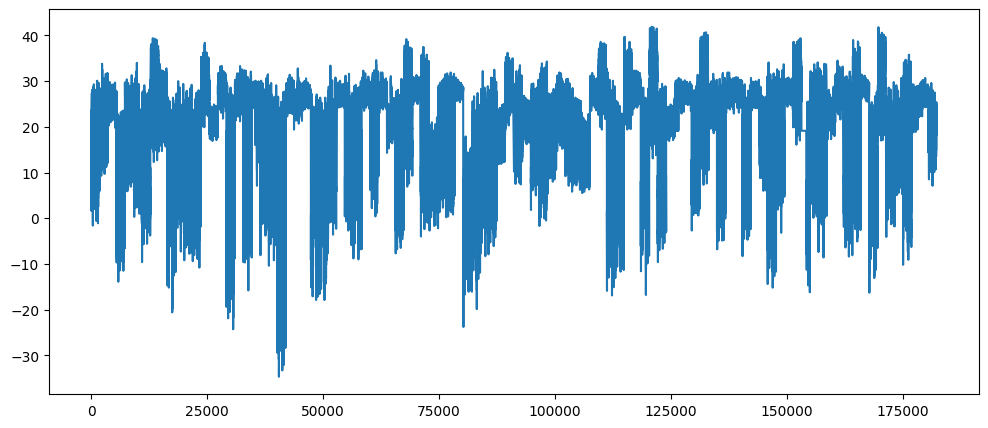

In [183]:
historical_weather['avg_temp_c'].plot(figsize=(12,5))

In [184]:
from statsmodels.tsa.stattools import adfuller

In [185]:
# def ad_test(dataset):
#      dftest = adfuller(dataset, autolag = 'AIC')
#      print("1. ADF : ",dftest[0])
#      print("2. P-Value : ", dftest[1])
#      print("3. Num Of Lags : ", dftest[2])
#      print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
#      print("5. Critical Values :")
#      for key, val in dftest[4].items():
#          print("\t",key, ": ", val)

# ad_test(historical_weather['avg_temp_c'])

In [186]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings("ignore")

# stepwise_fit = auto_arima(historical_weather['avg_temp_c'], trace=True,
# suppress_warnings=True)

In [187]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split


# Function to prepare data for ARIMA
def prepare_arima_data(df, city_id):
    city_df = df[df['city_id'] == city_id].sort_values('date')
    avg_temp_series = city_df['avg_temp_c'].dropna()
    return avg_temp_series

# Function to train ARIMA model
def train_arima(series, order=(2,1,2)):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    return model_fit

# Function to forecast future values using ARIMA model
def forecast_arima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

# Function to evaluate ARIMA model
def evaluate_arima(model, test_data):
    forecast = model.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, forecast)
    return mse

# List to store evaluation results and predictions for all cities
eval_results = []
future_predictions = []

# Iterate through all unique city IDs
unique_city_ids = historical_weather['city_id'].unique()

for city_id in unique_city_ids:
    avg_temp_series = prepare_arima_data(historical_weather, city_id)
    
    if len(avg_temp_series) > 0:  # Ensure there is enough data for training
        # Split data into train and test sets
        train_data, test_data = train_test_split(avg_temp_series, test_size=0.2, shuffle=False)
        
        # Train ARIMA model
        arima_model = train_arima(train_data)
        
        # Evaluate ARIMA model
        mse = evaluate_arima(arima_model, test_data)
        
        # Forecast future values
        forecast_steps = 7  # Forecast next 7 days
        future_forecast = forecast_arima(arima_model, forecast_steps)
        
        eval_results.append({
            'city_id': city_id,
            'mse': mse
        })
        
        future_predictions.append({
            'city_id': city_id,
            'forecast': future_forecast
        })

# Display evaluation results
for result in eval_results:
    print(f"City ID: {result['city_id']}, MSE: {result['mse']}")

# Display future predictions
for prediction in future_predictions:
    print(f"City ID: {prediction['city_id']}, Forecast for next 7 days: {prediction['forecast'].values}")

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Prog

City ID: 1, MSE: 96.89169572226261
City ID: 2, MSE: 58.01578083829884
City ID: 3, MSE: 5.263243295410793
City ID: 4, MSE: 151.82512647314383
City ID: 5, MSE: 88.66824054272539
City ID: 7, MSE: 64.0427549895835
City ID: 8, MSE: 97.3307835070652
City ID: 9, MSE: 124.10061608247324
City ID: 10, MSE: 119.6027914192996
City ID: 11, MSE: 193.79884701107756
City ID: 12, MSE: 56.74259143070494
City ID: 13, MSE: 137.51569241014076
City ID: 14, MSE: 122.84315032449577
City ID: 15, MSE: 19.86614074668125
City ID: 16, MSE: 2.0273198749890735
City ID: 17, MSE: 3.63300235825534
City ID: 18, MSE: 388.46955125677243
City ID: 20, MSE: 3.7356219728674684
City ID: 22, MSE: 981.9868700695099
City ID: 23, MSE: 6.168578172640693
City ID: 24, MSE: 66.2877171875865
City ID: 25, MSE: 97.07225449799452
City ID: 27, MSE: 688.5158622031176
City ID: 28, MSE: 2.4665725279041526
City ID: 29, MSE: 1.7497766953174891
City ID: 30, MSE: 1.3904668659988508
City ID: 31, MSE: 193.7450424394898
City ID: 33, MSE: 184.6495397

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next 

In [188]:
results = []

for city_prediction in future_predictions:
    city_id = city_prediction['city_id']
    predictions = city_prediction['forecast']
    for i, pred in enumerate(predictions):
        results.append({'city_id': city_id, 'day': i + 1, 'predicted_avg_temp_c': pred})

df_predictions = pd.DataFrame(results)

In [189]:
df_predictions

,city_id,day,predicted_avg_temp_c
0,1,1,10.848110
1,1,2,10.364744
2,1,3,10.138594
3,1,4,10.049404
4,1,5,10.018715
...,...,...,...
695,112,3,21.007252
696,112,4,21.057224
697,112,5,21.083268
698,112,6,21.095780


In [190]:
testt_data = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\submission_key.csv")

In [191]:
submission = pd.DataFrame({
    'submission_ID': testt_data['submission_ID'],
    'avg_temp_c': df_predictions['predicted_avg_temp_c']
})

# Save submission to CSV file
submission.to_csv('submission_Arima_1.csv', index=False)